In [1]:
import utils
import evaluators
import numpy as np
import pandas as pd
from matplotlib import pyplot

In [2]:
dataset = 'YelpChi'
path = 'Yelp_Dataset/'+dataset+'/metadata.gz'

In [3]:
reviews_array = np.array(utils.load_reviews(path))
reviews = pd.DataFrame(reviews_array, columns=['UserId', 'ProductId', 'Rating', 'Label', 'Date'])
reviews

No of Lines read# 67395


,UserId,ProductId,Rating,Label,Date
0,201,0,5.0,1,2011-06-08
1,202,0,3.0,1,2011-08-30
2,203,0,5.0,1,2009-06-26
3,204,0,1.0,1,2010-09-16
4,205,0,3.0,1,2010-02-05
...,...,...,...,...,...
67390,14981,199,5.0,1,2012-04-07
67391,38261,199,4.0,1,2009-06-05
67392,38262,200,5.0,1,2012-05-06
67393,26974,200,2.0,1,2011-01-08


In [4]:
one = 0
zero = 0
for x in reviews.Label:
    if x=='1':
        one += 1
    else:
        zero += 1
one, zero

(58476, 8919)

In [5]:
def extract_elite_accounts(elite_threshold):
    values, counts = np.unique(reviews.UserId, return_counts=True)
    elite_accounts = values[counts >= elite_threshold]
    print("No of elite accounts #", len(elite_accounts))
    return elite_accounts

In [6]:
print(len(np.unique(reviews.ProductId)) , len(np.unique(reviews.UserId)))

201 38063


In [7]:
def extract_target(total_targets):
    values, counts = np.unique(reviews.ProductId, return_counts=True)
    target_products = values[np.argsort(counts)][:total_targets]
    print("No of Targets: ", len(target_products))
    return target_products

In [8]:
def init(obj):
    obj_prob = {}
    for a in obj:
        obj_prob[a] = 1/len(obj)
    print(obj_prob)
    return obj_prob

In [9]:
def get_reviews(user_graph, product_graph, target_products, attack_p, elite_accounts, review_per_target, epsilon):
    new_reviews = []
    singleton_offset = 0
    target_attack_map = {}
    for index, target in enumerate(target_products):
        attack = utils.e_greedy_sample(attack_p, epsilon)
        target_attack_map[target] = attack
        new_reviews_1 = utils.get_new_reviews(user_graph, product_graph, attack, elite_accounts, review_per_target, singleton_offset, target)
        print(attack, len(new_reviews_1))
        new_reviews += new_reviews_1
        if attack == 'Singleton':
            singleton_offset += 1
    return new_reviews, target_attack_map
    

In [10]:
def play_min_max_game(attack_p, detect_q, episodes, elite_threshold, total_targets, review_per_target, learning_rate_attackors, learning_rate_detectors, epsilon, mode='Training'):
    LOSS = []
    PE = []
    recall = []
    all_attack_p = {attack: [attack_p[attack]] for attack in attack_p}
    all_detect_q = {detect: [detect_q[detect]] for detect in detect_q}
    
    target_attack_map = [{} for i in range(episodes)]
    
    elite_accounts = extract_elite_accounts(elite_threshold)
    target_products = extract_target(total_targets)
    user_graph = utils.convert_review_to_user_graph(reviews)
    product_graph = utils.convert_review_to_product_graph(reviews)
    
    old_ri, old_eri, old_revenue = evaluators.compute_revenue(product_graph, target_products, elite_accounts)
    old = [old_ri, old_eri, old_revenue]
    print("Old Revenue #", old_revenue)
        
        
    for i in range(episodes):
        print("Startng episode #", i)
        
        new_reviews, target_attack_map[i] = get_reviews(user_graph, product_graph, target_products, attack_p, elite_accounts, review_per_target, epsilon)
        
        
        spam_review_probs, sum_review_probs, detector_review_probs, top_k_reviews, new_product_graph = utils.run_detectors(user_graph, product_graph, new_reviews, detect_q, top_k)

        rem_new_reviews = [review for review in new_reviews if review not in top_k_reviews] 
        print("no of remaining_new_reviews ", len(rem_new_reviews))
        new_product_graph = utils.remove_edges(new_product_graph, top_k_reviews)

        new_ri, new_eri, new_revenue = evaluators.compute_revenue(new_product_graph, target_products, elite_accounts)
        new = [new_ri, new_eri, new_revenue]
        print("New Revenue #", new_revenue)
        
        cost = evaluators.compute_cost(old, new, rem_new_reviews, elite_accounts)

        rewards = evaluators.compute_reward(old, new, target_products)
        if mode == 'Training':
            attack_p = evaluators.update_p(attack_p, target_attack_map[i], rewards, learning_rate_attackors)
            attack_p = evaluators.normalize_map(attack_p)
        
            detect_q = evaluators.update_q(detect_q, cost, detector_review_probs, sum_review_probs, rem_new_reviews, learning_rate_detectors)

        practical_effect = evaluators.compute_pe(old, new, target_products)
        total_loss = evaluators.compute_loss(cost, spam_review_probs)
        
        LOSS.append(total_loss)
        PE.append(practical_effect)
        recall.append((len(rem_new_reviews), len(new_reviews)))
        for attack in attack_p:
            all_attack_p[attack].append(attack_p[attack])
        
        for detect in detect_q:
            all_detect_q[detect].append(detect_q[detect])
        
        print("Practical Effect: ", practical_effect)
        print("Total Loss: ", total_loss)
    return attack_p, detect_q, all_attack_p, all_detect_q, LOSS, PE, recall
    

In [11]:
elite_threshold = 10
attackors = ['IncBP', 'IncDS', 'IncPR', 'Random', 'Singleton']
detectors = ['GANG', 'Prior', 'SpEagle', 'fBox', 'Fraudar']
episodes = 50
total_targets = 5
epsilon = 0.1
review_per_target = 15
top_k = 0.01
learning_rate_attackors = 0.01
learning_rate_detectors = 30
attack_p = init(attackors)
detect_q = init(detectors)
attack_p, detect_q, all_attack_p, all_detect_q, LOSS, PE, recall = play_min_max_game(attack_p, detect_q, episodes, \
            elite_threshold, total_targets, review_per_target, learning_rate_attackors, learning_rate_detectors, epsilon)

{'IncBP': 0.2, 'IncDS': 0.2, 'IncPR': 0.2, 'Random': 0.2, 'Singleton': 0.2}
{'GANG': 0.2, 'Prior': 0.2, 'SpEagle': 0.2, 'fBox': 0.2, 'Fraudar': 0.2}
No of elite accounts # 536
No of Targets:  5
Old Revenue # {'187': 0.09638348320260925, '178': 0.13138348320260926, '173': 0.13138348320260926, '186': 0.09638348320260925, '194': 0.24138348320260924}
Startng episode # 0
Singleton 15
IncBP 15
Random 15
IncBP 15
IncDS 15
Run GANG ...
Run Prior ...
Run SpEagle ...
Run fBox ...
Run Fraudar ...
no of remaining_new_reviews  75
New Revenue # {'187': 0.12785959431274488, '178': 0.31004709431274485, '173': 0.31004709431274485, '186': 0.30592944725392135, '194': 0.31004709431274485}
Practical Effect:  0.6670129084918546
Total Loss:  0.004814475999410599
Startng episode # 1
IncDS 15
IncDS 15
IncDS 15
IncBP 15
IncDS 15
Run GANG ...
Run Prior ...
Run SpEagle ...
Run fBox ...
Run Fraudar ...
('6922', '194')
('6300', '194')
('5234', '194')
('7467', '187')
no of remaining_new_reviews  69
New Revenue # {'1

IncDS 15
Singleton 15
Random 15
Random 15
IncPR 15
Run GANG ...
Run Prior ...
Run SpEagle ...
Run fBox ...
Run Fraudar ...
('8802', '173')
('6596', '186')
('7870', '186')
('8902', '173')
('9102', '186')
('6245', '186')
('8231', '194')
('6332', '187')
('11535', '173')
no of remaining_new_reviews  56
New Revenue # {'187': 0.30850751507953067, '178': 0.13084084841286397, '173': 0.31084084841286397, '186': 0.3044772120492276, '194': 0.29811357568559127}
Practical Effect:  0.6558625836270312
Total Loss:  0.0019140447768204102
Startng episode # 18
IncDS 15
Random 15
Singleton 15
IncPR 15
IncDS 15
Run GANG ...
Run Prior ...
Run SpEagle ...
Run fBox ...
Run Fraudar ...
('5818', '178')
('7202', '186')
('7808', '186')
('13036', '178')
('8231', '186')
no of remaining_new_reviews  65
New Revenue # {'187': 0.3086264485735702, '178': 0.3108139485735702, '173': 0.1308139485735702, '186': 0.3044503122099338, '194': 0.30257865445592314}
Practical Effect:  0.6603658963735212
Total Loss:  0.0016089706165

IncPR 15
IncBP 15
IncDS 15
IncPR 15
IncDS 15
Run GANG ...
Run Prior ...
Run SpEagle ...
Run fBox ...
Run Fraudar ...
('7202', '187')
('5421', '186')
('9024', '187')
('5320', '186')
('8231', '187')
('5421', '187')
no of remaining_new_reviews  64
New Revenue # {'187': 0.30765743308459903, '178': 0.3108392512664172, '173': 0.3108392512664172, '186': 0.30447561490278086, '194': 0.3026039571487702}
Practical Effect:  0.8394980916559381
Total Loss:  0.0011124073928991218
Startng episode # 36
Random 15
IncDS 15
Random 15
IncPR 15
Singleton 15
Run GANG ...
Run Prior ...
Run SpEagle ...
Run fBox ...
Run Fraudar ...
('10139', '187')
('12434', '187')
('8802', '173')
('7861', '187')
('6504', '173')
('5421', '186')
('7202', '186')
no of remaining_new_reviews  64
New Revenue # {'187': 0.3078573659815724, '178': 0.310774032648239, '173': 0.310774032648239, '186': 0.305774032648239, '194': 0.302538738530592}
Practical Effect:  0.840800786443835
Total Loss:  0.0012105080205511356
Startng episode # 37
I

In [12]:
def plotData(x_axis_data, y_axis_data, x_label, y_label, curve_label=""):
    pyplot.plot(x_axis_data, y_axis_data, label=curve_label)
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)


In [13]:
attack_p, detect_q

({'IncBP': 0.18823563392446402,
  'IncDS': 0.28978851828788815,
  'IncPR': 0.1539328733388337,
  'Random': 0.18486802895146917,
  'Singleton': 0.183174945497345},
 {'GANG': 1.5295341516364362,
  'Prior': 0.7694130325968667,
  'SpEagle': 0.2030069968624976,
  'fBox': 0.3488647260793727,
  'Fraudar': 2.041987037201993})

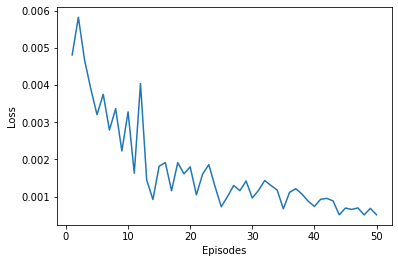

In [14]:
plotData(range(1, episodes+1), LOSS, "Episodes", "Loss")

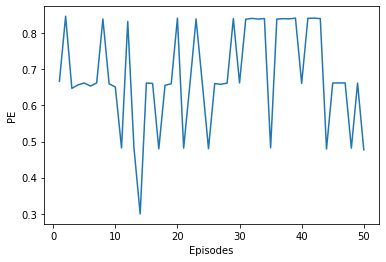

In [15]:
plotData(range(1, episodes+1), PE, "Episodes", "PE")

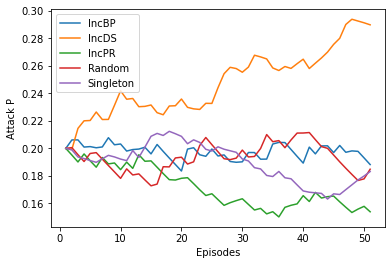

In [16]:
for attack in all_attack_p:
    plotData(range(1, episodes+2), all_attack_p[attack], "Episodes", "Attack P", attack)
pyplot.legend()
pyplot.show()

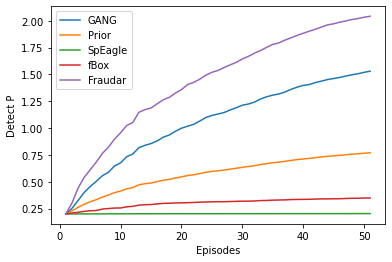

In [17]:
for detect in all_detect_q:
    plotData(range(1, episodes+2), all_detect_q[detect], "Episodes", "Detect P", detect)
pyplot.legend()
pyplot.show()

In [18]:
loss_detectors = []
detectors_l = []
for detect in detect_q:
    _,_,_,_, LOSS, PE, recall = play_min_max_game(attack_p, {detect: 1}, 1, \
            elite_threshold, total_targets, review_per_target, learning_rate_attackors, learning_rate_detectors, epsilon, "Testing")
    loss_detectors.append(LOSS[0])
    detectors_l.append(detect)
    
    print(detect, LOSS, PE)
_,_,_,_, nash_loss, PE, recall = play_min_max_game(attack_p, detect_q, 1, \
            elite_threshold, total_targets, review_per_target, learning_rate_attackors, learning_rate_detectors, epsilon, "Testing")
loss_detectors.append(nash_loss[0])
detectors_l.append("nash detect")

No of elite accounts # 536
No of Targets:  5
Old Revenue # {'187': 0.09638348320260925, '178': 0.13138348320260926, '173': 0.13138348320260926, '186': 0.09638348320260925, '194': 0.24138348320260924}
Startng episode # 0
IncDS 15
Singleton 15
IncDS 15
IncDS 15
IncBP 15
Run GANG ...
no of remaining_new_reviews  75
New Revenue # {'187': 0.3073801865653206, '178': 0.12956768656532067, '173': 0.30956768656532063, '186': 0.30545003950649713, '194': 0.3013323924476736}
Practical Effect:  0.6563805756370863
Total Loss:  0.003899144788296183
GANG [0.003899144788296183] [0.6563805756370863]
No of elite accounts # 536
No of Targets:  5
Old Revenue # {'187': 0.09638348320260925, '178': 0.13138348320260926, '173': 0.13138348320260926, '186': 0.09638348320260925, '194': 0.24138348320260924}
Startng episode # 0
IncPR 15
Random 15
Random 15
IncDS 15
IncBP 15
Run Prior ...
no of remaining_new_reviews  75
New Revenue # {'187': 0.3081673276308933, '178': 0.3103548276308933, '173': 0.3103548276308933, '18

['GANG', 'Prior', 'SpEagle', 'fBox', 'Fraudar', 'nash detect']
[0.003899144788296183, 0.006567397787617612, 0.006108031793094214, 0.005860574768203354, 0.0038044327082320485, 0.0005292753455255129]


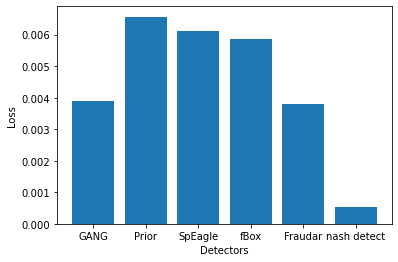

In [22]:
#plotData(detectors_l, loss_detectors, "Detectors", "Loss")
print(detectors_l)
print(loss_detectors)
pyplot.bar(np.array(detectors_l), np.array(loss_detectors))
pyplot.xlabel("Detectors")
pyplot.ylabel("Loss")
pyplot.show()